In [119]:
%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict
import copy
from omegaconf import OmegaConf
from datetime import datetime

import scipy.stats as stats
import numpy as np
import jsonlines
from pathlib import Path
from hydra import initialize, compose
import torchvision

import dr_util.file_utils as fu
import dr_gen.utils.model as mu
import dr_gen.utils.run as ru

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Config and Generator

In [2]:
with initialize(config_path="../configs/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
    )

In [3]:
generator = ru.set_deterministic(cfg.seed)

### Utils

#### Log Loading and Parsing

In [87]:
# Return a list of [(file_path, file_contents), ...]
def get_all_logs(base_dir):
    print(f">> Getting logs from all runs in: {base_dir}")
    log_dir = Path(base_dir)
    all_files = [f for f in log_dir.rglob("*.jsonl") if f.is_file()]
    print(f">>    found files: {len(all_files)}")
    return [(str(f), fu.load_file(str(f))) for f in all_files]

In [148]:
# Extract from logs: cfg, metrics[split] = [{k: v}, ...], metadata
def parse_run_log(log_file, log_data):
    # Setup the run metadata
    run_metadata = {
        "error_info": [],
        "parsed_log_file": log_file,
        "parse_time": datetime.now(),
        "train_time": None,
    }
    if len(log_data) < 2:
        run_metadata["error_info"].append(f">> file length: {len(log_data)}")
        return None, None, run_metadata
    
    # Cfg should be logged as the first line
    if "type" not in log_data[0] or log_data[0]['type'] != "dict_config":
        run_metadata["error_info"].append(">> Log file doesn't have cfg as first line")
        return None, None, run_metadata

    # Get the train_time from the logs
    run_cfg = copy.deepcopy(log_data[0].get("value", {}))
    if log_data[-2].get("type", None) == "str" and "value" in log_data[-2]:
        run_metadata["train_time"] = log_data[-2]['value'].strip("Training time ")
        
    # Extract the metrics from rest of logged lines
    metrics = defaultdict(list)
    epoch = defaultdict(int)
    for l in log_data[1:-1]:
        # Skip all the logged strings
        if l.get("type", None) == "str":
            continue


        # If the data has a name and agg_stats, collect it
        split = l.get("data_name", None)
        stats = l.get("agg_stats", None)
        if split is not None and stats is not None:
            metrics[split].append({"epoch": epoch[split], **stats})
            epoch[split] += 1

    # Do some verification
    expected_epochs = run_cfg['epochs']
    for k, v in metrics.items():
        if v[-1]['epoch'] != expected_epochs - 1:
            run_metadata['error_info'].append(
                f">> {k} only has {v[-1]['epoch']+1} / {expected_epochs} epochs"
            )
        
    return run_cfg, dict(metrics), run_metadata

In [149]:
# Parse all run logs
def parse_run_logs(all_files_data):
    runs_cfg_metrics_metadata = []
    for file_path, contents in all_files_data:
        runs_cfg_metrics_metadata.append(
            parse_run_log(file_path, contents)
        )
    return runs_cfg_metrics_metadata

In [172]:
# Selects runs that finished without error that match criteria (None == any)
#    returns a list of [(cfg, metrics, metadta), ...] for selected
#    and a list of error runs
def filter_parsed_runs(parsed_rs, lr=None, wd=None, init=None):
    subset = []
    error_subset = []
    for cf, ms, md in parsed_rs:
        # Check for errors in run
        # - first runs that aren't finished
        if cf is None or ms is None or len(md['error_info']):
            error_subset.append((cf, ms, md))
            continue
        # - then runs that don't have values for sweep vals
        if cf['optim']['lr'] == '' or cfg['optim']['weight_decay'] == '':
            error_subset.append((cf, ms, md))
            continue

        # Then skip good runs that don't match filter criteria
        if lr is not None and float(cf['optim']['lr']) != lr:
            continue
        if wd is not None and float(cf['optim']['weight_decay']) != wd:
            continue
        if init == "random" and cf['model']['weights'] is not None:
            continue
        elif init == "pretrained" and cf['model']['weights'] != "DEFAULT":
            continue

        # Finally add matching good runs to our run list
        subset.append((cf, ms, md))

    return subset, error_subset

In [175]:
# Filter out error runs and split the parsed runs by sweep metrics
# Returns {"group_name": [(cfg, metrics, metadata), ...]} and a list of error runs
#     metrics = {"split": [{"epoch": ..., metric_name: value, ...}, ....]
def get_run_groups(
    parsed_rs,
    lrs=[0.01, 0.1, 0.2], wds=[1e-4, 1e-5],
    inits=["random", "pretrained"],
):
    good_runs, error_runs = filter_parsed_runs(
        parsed_rs, lr=None, wd=None, init=None, # None == any
    )
    
    run_groups = {}
    for init in inits:
        for lr in lrs:
            for wd in wds:
                rgs, _ = filter_parsed_runs(
                    good_runs, lr=lr, wd=wd, init=init,
                )
                group_name = f'{init}_lr{lr}_wd{wd}' 
                if len(rgs) > 0:
                    print(f" - {group_name:30} | found {len(rgs)}")
                    run_groups[f'{init}_lr{lr}_wd{wd}'] = rgs
                else:
                    print(f" - {group_name:30} | No runs")
    print(f">> Total error or unfinished runs: {len(error_runs)}")
    return run_groups, error_runs

In [197]:
def extract_all_run_group_metrics(
    run_group,
    splits=['train', 'val', 'eval'],
    metric_names=['epoch', 'loss', 'acc1', 'acc5'],
):
    # input: [(cfg, run_met, md) for run in run_group]
    #        run_met = {split: [{"epoch": ..., "metric_name": val, ...} for epochs]}
    # goal: { split: metric_name: [values_list for run in run_group] }
    metrics = {spl: {mn: [] for mn in metric_names} for spl in splits}
    for _, run_metrics, _ in run_group: # iterate through runs
        for split in splits:
            epoch_list = run_metrics[split]
            for mn in metric_names:
                metrics[split][mn].append( # append one list per run to mn
                    [vdict[mn] for vdict in epoch_list]
                )
    return metrics

In [189]:
def get_run_groups_metrics(run_groups):
    rg_metrics = {}
    for name, group_data in run_groups.items():
        rg_metrics[name] = extract_all_run_group_metrics(group_data)
    return rg_metrics

#### Basic Plotting

In [12]:
def get_plt_cfg(**kwargs):
    base_plt_cfg = OmegaConf.create({
        "figsize": (10, 6),
        "legend": False,
        "grid": True,
        "nbins": 10,
        "hist_range": None,
        "title": None,
        "xlabel": None,
        "ylabel": None,
        "labels": None,
    })
    plc = base_plt_cfg.copy()
    plc.hist_range = (80.0, 100.0)
    plc.nbins = 100
    plc.legend = True

    for k, v in kwargs.items():
        if k in plc:
            plc[k] = v
    return plc

In [71]:
def plot_parsed_metrics(plc, tm, lr="", wd="", initialization=""):
    # Extract acc1 values from each entry in data['train']
    acc1_values = [entry['agg_stats']['acc1'] for entry in tm['train']]
    acc1_val = [entry['agg_stats']['acc1'] for entry in tm['val']]
    acc1_eval = [entry['agg_stats']['acc1'] for entry in tm['eval']]
    
    # Create an index for each data point (0, 1, 2, ...)
    indices = list(range(len(acc1_values)))

    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default
    
    # Plotting
    plt.figure(figsize=plc.figsize)
    plt.plot(indices, acc1_values, linestyle='-', label="train")
    plt.plot(indices, acc1_val, linestyle='-', label="val")
    plt.plot(indices, acc1_eval, linestyle='-', label="eval")
    plt.xlabel(plcv("xlabel", "Epoch"))
    plt.ylabel(plcv("ylabel", "Accuracy"))
    plt.title(plcv(
        "title", 
        f"Accuracy During Training, lr{lr}, wd{wd}, {initialization}"
    ))
    plt.grid(plc.grid)
    if plc.legend:
        plt.legend()
    plt.show()

In [36]:
def plot_parsed(plc, conf, metrics):
    plot_parsed_metrics(
        plc,
        metrics,
        lr=conf['optim']['lr'],
        wd=conf['optim']['weight_decay'],
        initialization="Random Init" if conf['model']['weights'] is None else conf['model']['weights'],
    )
    

In [222]:
def plot_histogram(plc, group_metrics, epoch, split, metric_name="acc1"):
    # [metric_by_epoch for run in run_group]
    all_runs_all_epochs_metrics = group_metrics[split][metric_name]
    # Get metrics for epoch
    metric_for_target_epoch_all_runs = [
        l[epoch] for l in all_runs_all_epochs_metrics if epoch < len(l)
    ]
        
    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default

    # Plot the histogram using matplotlib
    plt.figure(figsize=plc.figsize)
    plt.hist(
        metric_for_target_epoch_all_runs,
        bins=plc.nbins, edgecolor='black', range=plc.hist_range,
    )
    plt.xlabel(plcv("xlabel", "acc1"))
    plt.ylabel(plcv("ylabel", "Frequency"))
    plt.title(plcv(
        "title",
        f"Histogram of {metric_name} values (split='{split}', epoch={epoch})"
    ))
    plt.grid(plc.grid)
    plt.show()

In [225]:
def plot_histograms(plc, group_metrics, epoch, metric_name="acc1", splits=["train", "val", "eval"]):
    # Set up a color map for splits.
    default_colors = {"train": "blue", "val": "green", "eval": "red"}
    colors = {split: default_colors.get(split, None) for split in splits}
    plt.figure(figsize=plc.figsize)

    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default
    
    # Plot histogram for each split using histtype 'step' for overlay.
    for split in splits:
        # [metric_by_epoch for run in run_group]
        all_runs_all_epochs_metrics = group_metrics[split][metric_name]
        # Get metrics for epoch
        metric_for_target_epoch_all_runs = [
            l[epoch] for l in all_runs_all_epochs_metrics if epoch < len(l)
        ]
        plt.hist(
            metric_for_target_epoch_all_runs,
            bins=plc.nbins,
            edgecolor=colors[split],
            range=plc.hist_range,
            histtype='step',
            label=split,
        )
    
    plt.xlabel(plcv("xlabel", "acc1"))
    plt.ylabel(plcv("ylabel", "Frequency"))
    plt.title(plcv("title", f"Histogram of acc1 values at index {epoch} for splits {', '.join(splits)}"))
    if plc.legend:
        plt.legend()
    plt.grid(plc.grid)
    plt.show()

#### Stat Calculation

In [31]:
def extract_values(run_set1, run_set2, index, split_name):
    # Extract acc1 values for the first run set.
    acc1_vals1 = []
    for run in run_set1:
        run_name, run_config, run_metrics = run
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                acc1_vals1.append(acc1)
    
    # Extract acc1 values for the second run set.
    acc1_vals2 = []
    for run in run_set2:
        run_name, run_config, run_metrics = run
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                acc1_vals2.append(acc1)
    
    if not acc1_vals1 or not acc1_vals2:
        print(f"Insufficient data for split '{split_name}' at index {index} in one or both run sets.")
        return None, None
    return acc1_vals1, acc1_vals2

In [30]:
def find_max_diff_point(values1, values2):
    """
    Given two lists of numeric values, compute their empirical CDFs
    and return the value at which the absolute difference between
    the two CDFs is maximized. Also return the KS statistic and the
    corresponding CDF values for each group.
    
    Parameters:
        values1 (list or np.ndarray): The first set of numeric values.
        values2 (list or np.ndarray): The second set of numeric values.
        
    Returns:
        max_diff_value (float): The x-value at which the maximum difference occurs.
        ks_stat (float): The maximum absolute difference (KS statistic).
        cdf1 (float): The empirical CDF of values1 at max_diff_value.
        cdf2 (float): The empirical CDF of values2 at max_diff_value.
    """
    v1 = np.sort(np.array(values1))
    v2 = np.sort(np.array(values2))
    
    # Combine both arrays and get unique sorted values.
    all_vals = np.sort(np.unique(np.concatenate([v1, v2])))
    
    # For each unique value, compute the proportion of values in each sample that are <= that value.
    cdf1 = np.searchsorted(v1, all_vals, side='right') / len(v1)
    cdf2 = np.searchsorted(v2, all_vals, side='right') / len(v2)
    
    # Compute absolute differences between the two CDFs.
    differences = np.abs(cdf1 - cdf2)
    max_idx = np.argmax(differences)
    max_diff_value = all_vals[max_idx]
    ks_stat = differences[max_idx]
    
    return max_diff_value, ks_stat, cdf1[max_idx], cdf2[max_idx]

In [32]:
def calculate_ks_for_run_sets(run_set1, run_set2, index, split_name):
    acc1_vals1, acc1_vals2 = extract_values(run_set1, run_set2, index, split_name)
    
    # Compute the KS statistic and p-value.
    ks_stat, p_value = stats.ks_2samp(acc1_vals1, acc1_vals2)

    # Identify contributing samples
    max_val, ks_stat, cdf1_val, cdf2_val = find_max_diff_point(acc1_vals1, acc1_vals2)
    print(f"ks_stat: {ks_stat:0.4f}, p_value: {p_value:0.4e} | max_val: {max_val:0.2f}, cdf1_val: {cdf1_val:0.4f}, cdf2_val: {cdf2_val:0.4f}")
    
    return ks_stat, p_value

#### Advanced Plotting

In [29]:
def plot_split_histogram_two_run_sets(run_set1, run_set2, index, split_name, hist_range=None, nbins=10, names=['Set 1', 'Set 2'], title=None):
    """
    Plots overlaid histograms of the 'acc1' metric at a given index for a specified split,
    comparing two different run sets on the same plot.
    
    Parameters:
        run_set1 (list): A list of runs. Each run is a tuple 
                         (run_name, run_config, run_metrics), where run_metrics is a dict
                         mapping split names (e.g. 'train') to a list of metric dicts.
        run_set2 (list): Another list of runs with the same structure.
        index (int): The index into the list of metrics for the given split.
        split_name (str): The split to extract from ('train', 'val', or 'eval').
        hist_min (float, optional): Minimum value for the histogram bins.
        hist_max (float, optional): Maximum value for the histogram bins.
    """
    # Extract acc1 values for run_set1
    values1 = []
    for run in run_set1:
        run_name, run_config, run_metrics = run
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                values1.append(acc1)
                
    # Extract acc1 values for run_set2
    values2 = []
    for run in run_set2:
        run_name, run_config, run_metrics = run
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                values2.append(acc1)
                
    # Check if there is data to plot
    if not values1 and not values2:
        print(f"No valid 'acc1' values found for split '{split_name}' at index {index} in both run sets.")
        return
    if not values1:
        print(f"No valid 'acc1' values found for split '{split_name}' at index {index} in run set 1.")
    if not values2:
        print(f"No valid 'acc1' values found for split '{split_name}' at index {index} in run set 2.")
    
    # Define the histogram range if bounds are provided
    #hist_range = (hist_min, hist_max) if (hist_min is not None and hist_max is not None) else None

    plt.figure(figsize=(10, 6))
    
    # Plot histogram for run set 1 in blue
    if values1:
        plt.hist(values1, bins=nbins, histtype='step', edgecolor='blue', range=hist_range, label=names[0])
        mean1 = sum(values1) / len(values1)
        plt.axvline(mean1, color='blue', linestyle='dashed', linewidth=1.5, label=f'{names[0]} Mean: ({mean1:.2f})')
        
    # Plot histogram for run set 2 in red
    if values2:
        plt.hist(values2, bins=nbins, histtype='step', edgecolor='red', range=hist_range, label=names[1])
        mean2 = sum(values2) / len(values2)
        plt.axvline(mean2, color='red', linestyle='dashed', linewidth=1.5, label=f'{names[1]} Mean: ({mean2:.2f})')
        
    plt.xlabel("acc1")
    plt.ylabel("Frequency")
    plt.title(title if title is not None else f"Histogram of acc1 values for split '{split_name}' at index {index}")
    plt.legend()
    plt.grid(True)
    plt.show()


### Find Relevant Logs & Basic Plotting

In [121]:
run_logs = get_all_logs("/scratch/ddr8143/logs")

>> Getting logs from all runs in: /scratch/ddr8143/logs
>>    found files: 333


In [147]:
parsed_cfg_metrics_meta = parse_run_logs(run_logs)
# excfg, exmets, exmeta = parsed_cfg_metrics_meta[0]

In [170]:
run_groups, error_runs = get_run_groups(parsed_cfg_metrics_meta)

 - random_lr0.01_wd0.0001         | found 20
 - random_lr0.01_wd1e-05          | found 20
 - random_lr0.1_wd0.0001          | found 100
 - random_lr0.1_wd1e-05           | found 20
 - random_lr0.2_wd0.0001          | found 20
 - random_lr0.2_wd1e-05           | found 20
 - pretrained_lr0.01_wd0.0001     | found 20
 - pretrained_lr0.01_wd1e-05      | found 5
 - pretrained_lr0.1_wd0.0001      | found 91
 - pretrained_lr0.1_wd1e-05       | No runs
 - pretrained_lr0.2_wd0.0001      | No runs
 - pretrained_lr0.2_wd1e-05       | No runs
>> Total error or unfinished runs: 17


In [199]:
run_group_metrics = get_run_groups_metrics(run_groups)

In [203]:
print(run_group_metrics['random_lr0.1_wd0.0001']['train'].keys())
print(len(run_group_metrics['random_lr0.1_wd0.0001']['train']['loss']))
print(len(run_group_metrics['random_lr0.1_wd0.0001']['train']['loss'][0]))
print(run_group_metrics['random_lr0.1_wd0.0001']['train']['loss'][0][:4])

dict_keys(['epoch', 'loss', 'acc1', 'acc5'])
100
270
[2.247946374118328, 1.9303486838936805, 1.6153231889009476, 1.5180175349116325]


>> Run: /scratch/ddr8143/logs/cifar10_scratch/bs500/lr0.1/wd0.0001/s3/2025-02-25/00-28-1740461321/json_out.jsonl


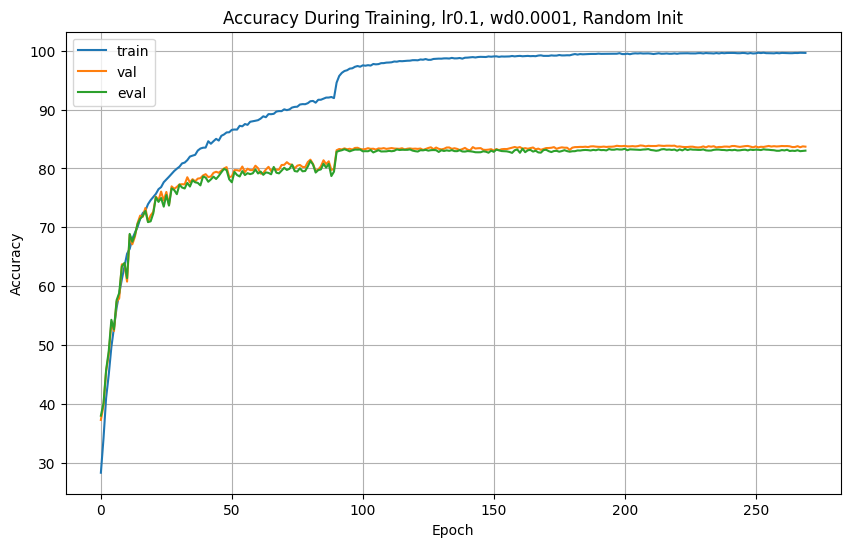

In [72]:
# Plot an example run
ex_run_file, ex_run_cfg, ex_run_mds = run_groups['random_lr0.1_wd0.0001'][0]

print(f">> Run: {ex_run_file}")
plot_parsed(get_plt_cfg(), ex_run_cfg, ex_run_mds)

### Plotting V2

### Compare random vs pretrained weight inits

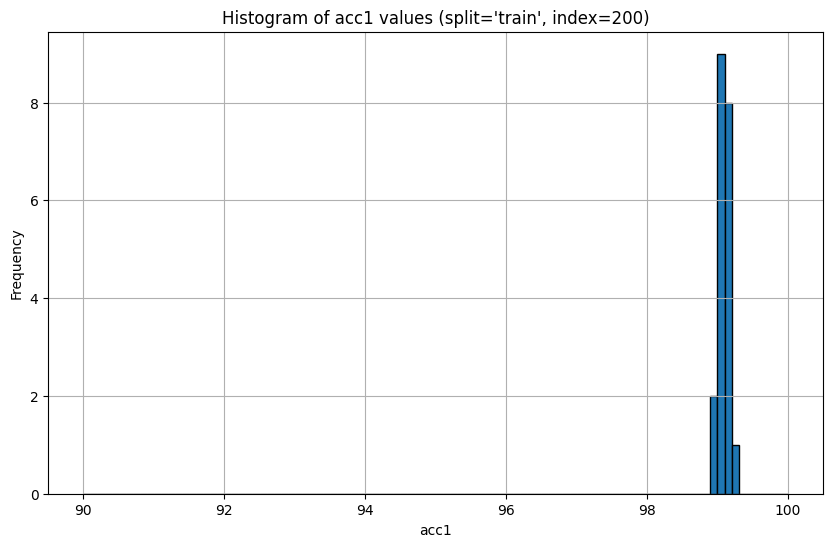

In [34]:
plot_acc1_histogram(lower_lr_random_runs, 200, "train", (90.0, 100.0), 100)

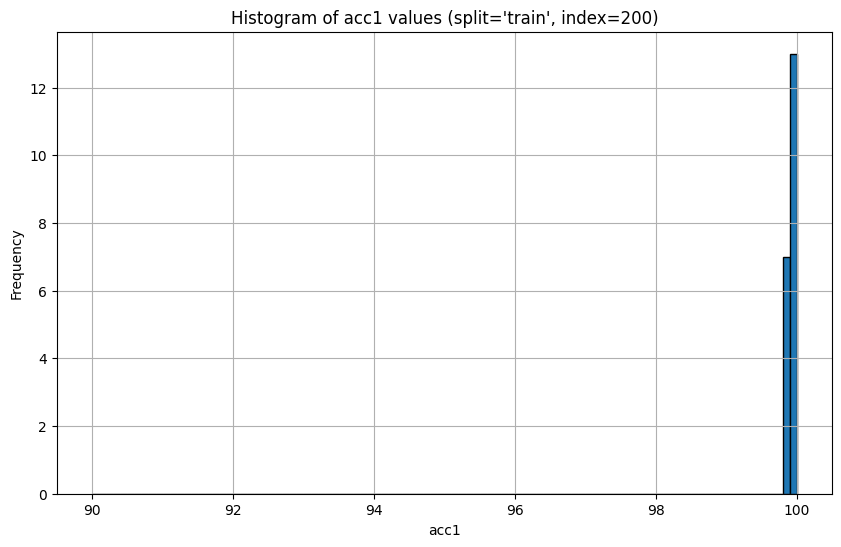

In [35]:
plot_acc1_histogram(lower_lr_pretrained_runs, 200, "train", (90.0, 100.0), 100)

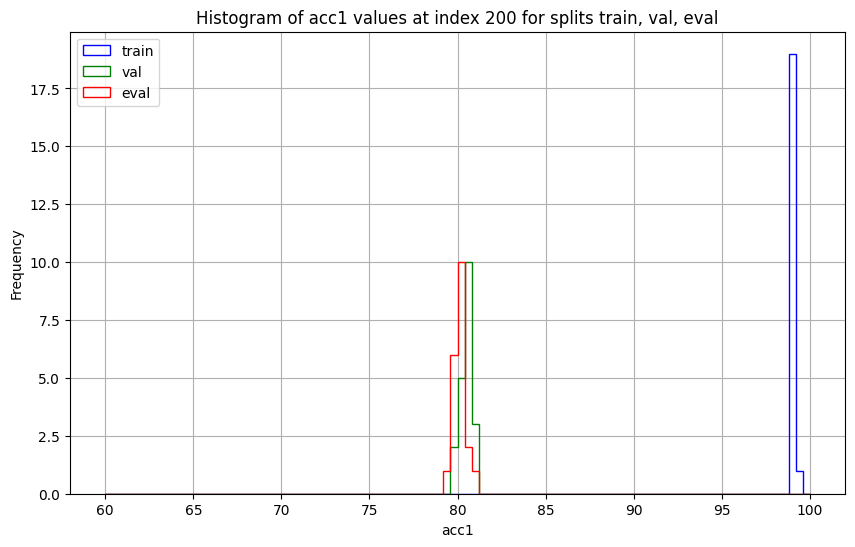

In [36]:
plot_acc1_histograms(lower_lr_random_runs, 200, ["train", "val", "eval"], (60.0, 100.0), 100)

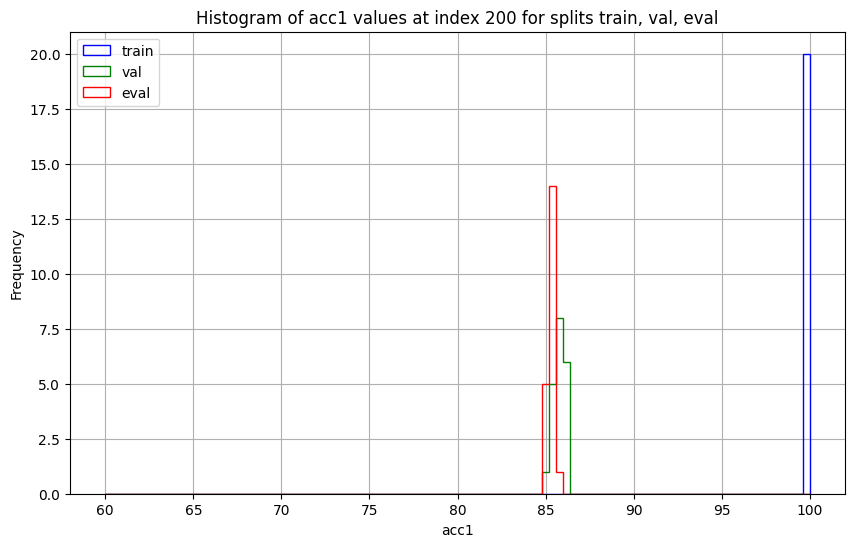

In [37]:
plot_acc1_histograms(lower_lr_pretrained_runs, 200, ["train", "val", "eval"], (60.0, 100.0), 100)

In [59]:
def present_stats(rs1, rs2, lb1, lb2, title, index, split, hist_range, nbins):
    plot_split_histogram_two_run_sets(
        rs1, rs2,
        index=index,
        split_name=split,
        hist_range=hist_range,
        nbins=nbins,
        names=[lb1, lb2],
        title=title,
    )
    ks_stat, p_value = calculate_ks_for_run_sets(
        rs1, rs2,
        index=index,
        split_name=split,
    )

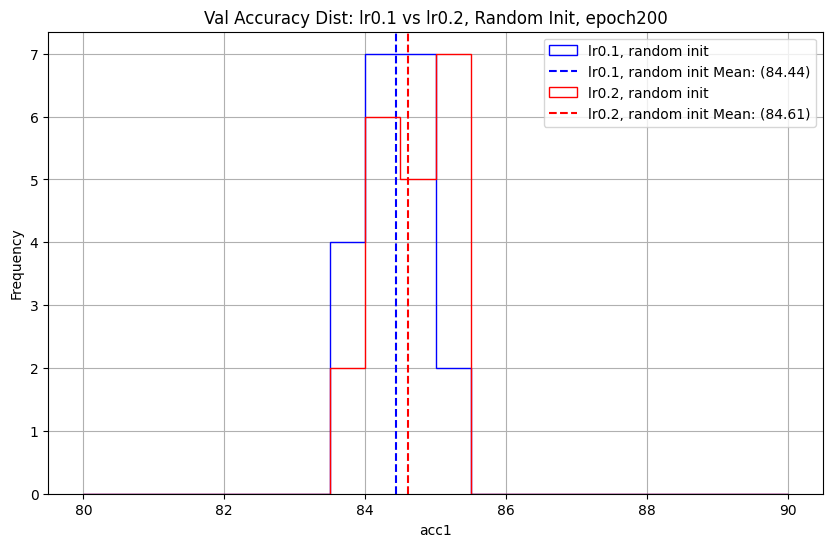

ks_stat: 0.3000, p_value: 3.3559e-01 | max_val: 84.81, cdf1_val: 0.9000, cdf2_val: 0.6000


In [65]:
present_stats(
    default_hpm_random_runs, higher_lr_random_runs,
    "lr0.1, random init", "lr0.2, random init",
    "Val Accuracy Dist: lr0.1 vs lr0.2, Random Init, epoch200",
    index=200, split="val", hist_range=(80,90), nbins=20,
)

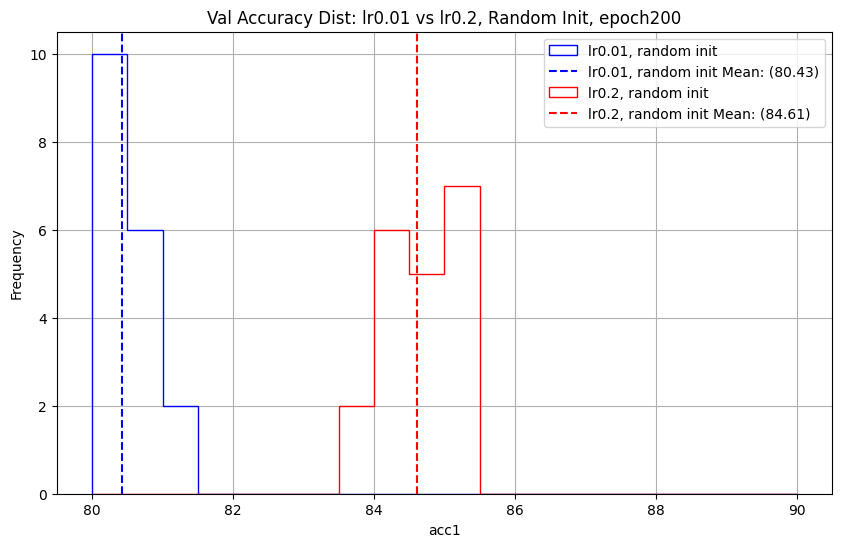

ks_stat: 1.0000, p_value: 1.4509e-11 | max_val: 81.10, cdf1_val: 1.0000, cdf2_val: 0.0000


In [66]:
present_stats(
    lower_lr_random_runs, higher_lr_random_runs,
    "lr0.01, random init", "lr0.2, random init",
    "Val Accuracy Dist: lr0.01 vs lr0.2, Random Init, epoch200",
    index=200, split="val", hist_range=(80,90), nbins=20,
)

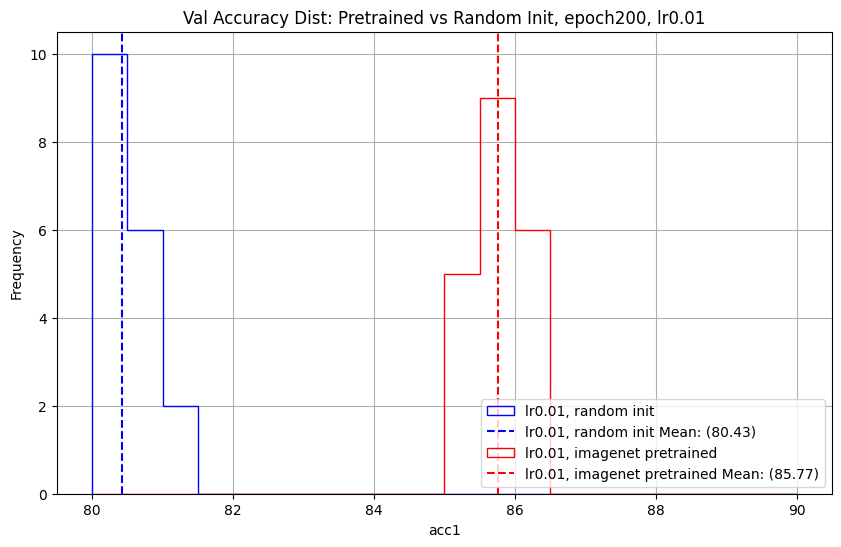

ks_stat: 1.0000, p_value: 1.4509e-11 | max_val: 81.10, cdf1_val: 1.0000, cdf2_val: 0.0000


In [63]:
present_stats(
    lower_lr_random_runs, lower_lr_pretrained_runs,
    "lr0.01, random init", "lr0.01, imagenet pretrained",
    "Val Accuracy Dist: Pretrained vs Random Init, epoch200, lr0.01",
    index=200, split="val", hist_range=(80,90), nbins=20,
)

### Plot Comparitive Histograms

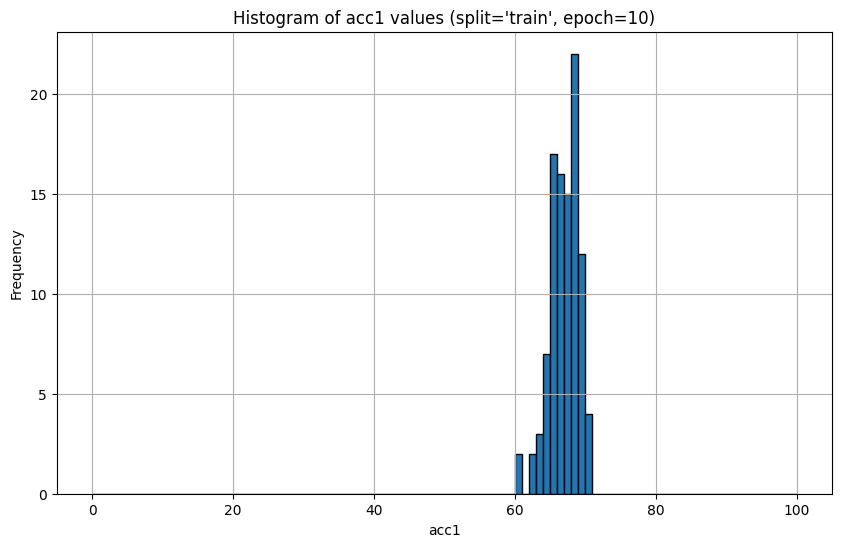

In [223]:
plot_histogram(
    get_plt_cfg(
        legend=True, labels=["random_lr0.1_wd0.0001"], hist_range=(0, 100),
    ),
    run_group_metrics['random_lr0.1_wd0.0001'],
    epoch=10,
    split="train",
)

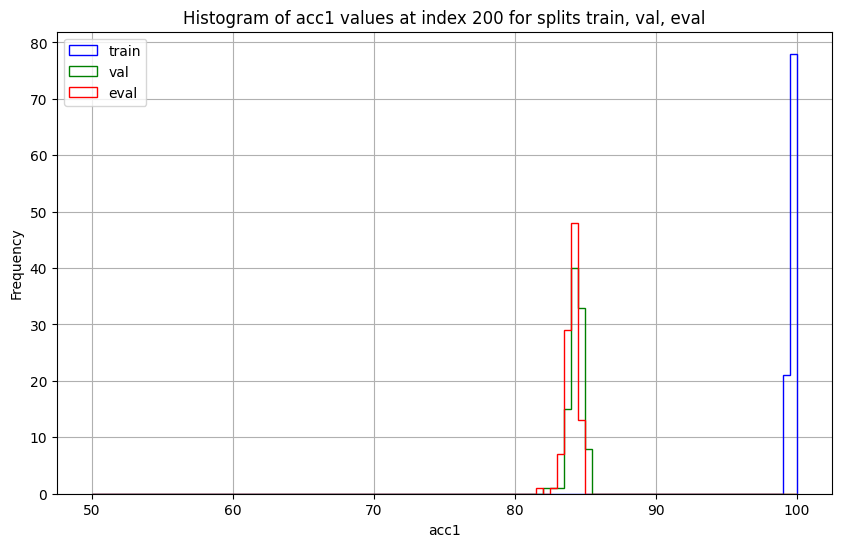

In [229]:
plot_histograms(
    get_plt_cfg(
        legend=True, labels=["train", "val", "eval"], hist_range=(50, 100),
    ),
    run_group_metrics['random_lr0.1_wd0.0001'],
    epoch=200,
    splits=["train", "val", "eval"],
)

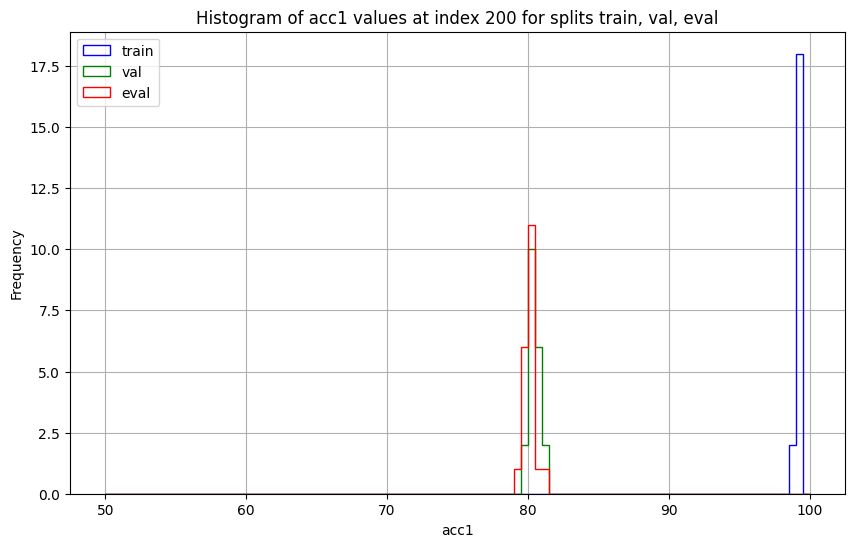

In [228]:
plot_histograms(
    get_plt_cfg(
        legend=True, labels=["train", "val", "eval"], hist_range=(50, 100),
    ),
    run_group_metrics['random_lr0.01_wd0.0001'],
    epoch=200,
    splits=["train", "val", "eval"],
)

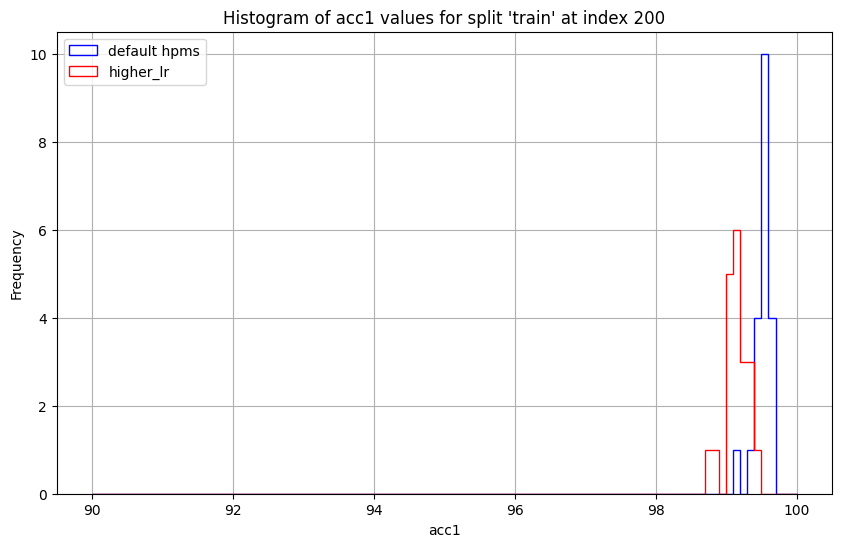

In [98]:
plot_split_histogram_two_run_sets(
    default_hpm_random_runs, higher_lr_random_runs, index=200, split_name="train", hist_range=(90,100), nbins=100, names=['default hpms', 'higher_lr']
)

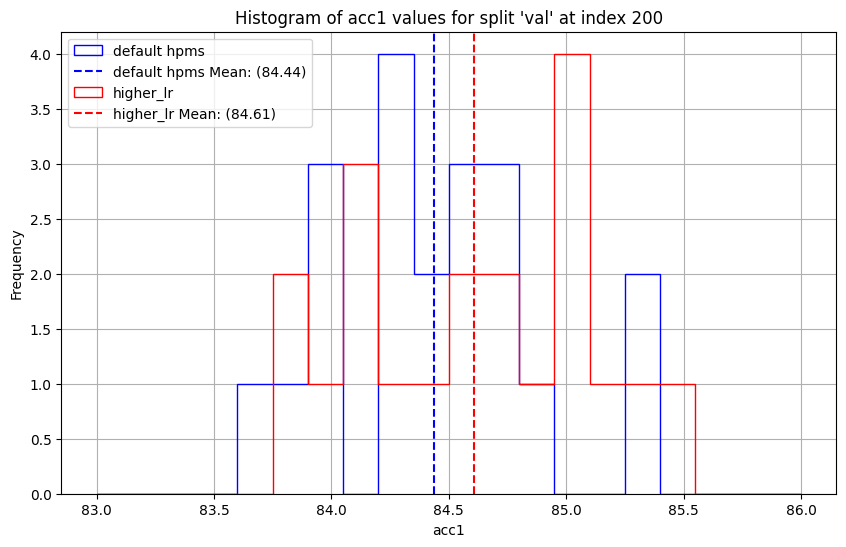

In [104]:
plot_split_histogram_two_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name="val", hist_range=(83,86), nbins=20, names=['default hpms', 'higher_lr'])

### KS Statistics

In [144]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name='val')

ks_stat: 0.3000, p_value: 3.3559e-01 | max_val: 84.81, cdf1_val: 0.9000, cdf2_val: 0.6000


In [145]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=50, split_name='val')

ks_stat: 0.5619, p_value: 1.6568e-03 | max_val: 79.40, cdf1_val: 0.2381, cdf2_val: 0.8000


In [146]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name='train')

ks_stat: 0.9000, p_value: 1.1317e-08 | max_val: 99.41, cdf1_val: 0.1000, cdf2_val: 1.0000


In [147]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=50, split_name='train')

ks_stat: 0.9524, p_value: 1.5606e-10 | max_val: 85.59, cdf1_val: 0.0476, cdf2_val: 1.0000


In [148]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, default_hpm_random_runs, index=50, split_name='val')

ks_stat: 0.0000, p_value: 1.0000e+00 | max_val: 78.53, cdf1_val: 0.0476, cdf2_val: 0.0476
